In [113]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys

if "../" not in sys.path:
  sys.path.append("../") 

from collections import defaultdict
from lib.envs.cliff_walking import CliffWalkingEnv
from lib.envs.gridworld import GridworldEnv
from lib.envs.windy_gridworld import WindyGridworldEnv
from lib.envs.blackjack import BlackjackEnv
from lib import plotting


matplotlib.style.use('ggplot')

In [114]:
env = CliffWalkingEnv()
env = GridworldEnv()
env = WindyGridworldEnv()
#env = BlackjackEnv()

In [115]:
def make_epsilon_greedy_policy_doubleQ(Q1, Q2, epsilon, nA):
    def policy_fn(observation):        
        
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q1[observation]+Q2[observation])
        
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):        
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [116]:
def one_step_lookahead(state, policy):
    prob = policy(state)
    return np.random.choice(range(len(prob)), p=prob)



def double_q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q1 = defaultdict(lambda: np.zeros(env.action_space.n))
    Q2 = defaultdict(lambda: np.zeros(env.action_space.n))

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    policy = make_epsilon_greedy_policy_doubleQ(Q1, Q2, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
       # if (i_episode + 1) % 100 == 0:
       #     print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes))
       #     sys.stdout.flush()
            
        s = env.reset()
        done = False
        
        while not done:
            a = one_step_lookahead(s, policy)
            sp, r, done, _ = env.step(a)
            
            
            if np.random.uniform() < 0.5:
                Q1[s][a] += alpha*(r+discount_factor*Q2[sp][np.argmax(Q1[sp])] - Q1[s][a])
            else:
                Q2[s][a] += alpha*(r+discount_factor*Q1[sp][np.argmax(Q1[sp])] - Q2[s][a])                
                    
            s = sp
            
            
        
            stats.episode_rewards[i_episode] += r
            stats.episode_lengths[i_episode] += 1
                
    return Q, stats, policy    
    
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Lambda time discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
      #  if (i_episode + 1) % 100 == 0:
            #print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes))
        #    sys.stdout.flush()
            
        s = env.reset()
        done = False
        
        while not done:
            a = one_step_lookahead(s, policy)
            sp, r, done, _ = env.step(a)
            Q[s][a] += alpha*(r+discount_factor*np.max(Q[sp]) - Q[s][a])
            s = sp
        
            stats.episode_rewards[i_episode] += r
            stats.episode_lengths[i_episode] += 1
                
    return Q, stats, policy

In [117]:
Q, stats, policy = double_q_learning(env, 200, discount_factor=1., alpha=0.9)

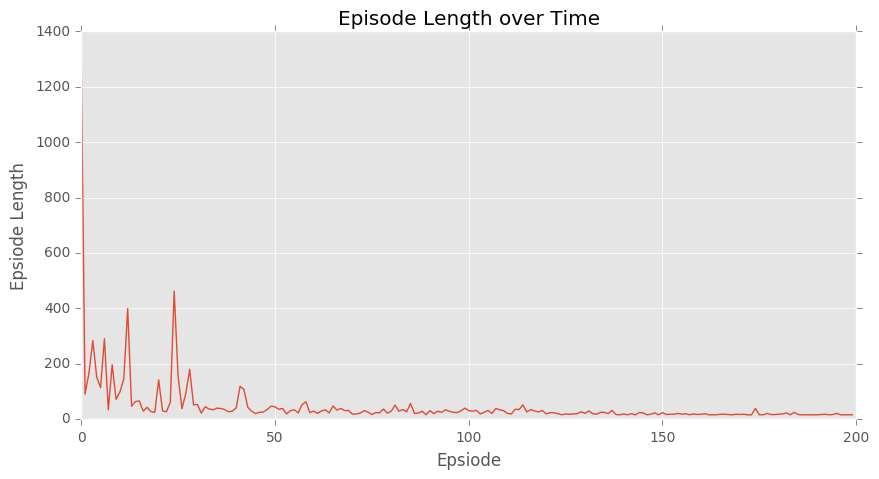

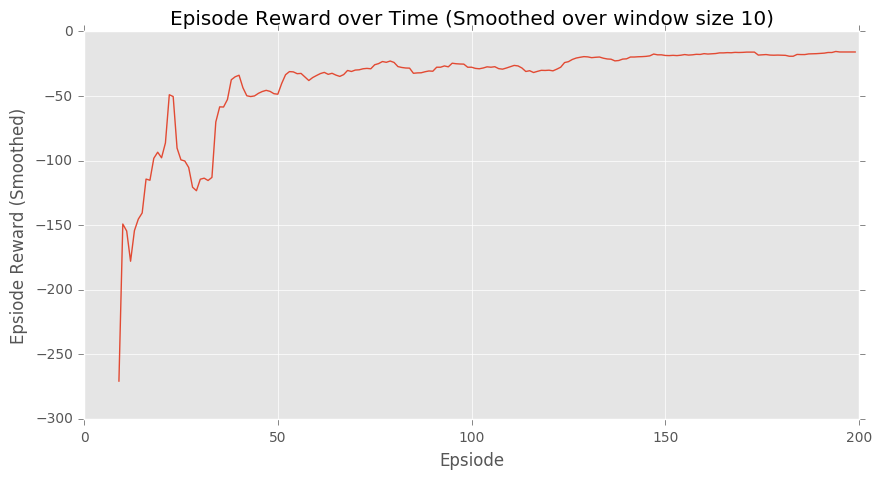

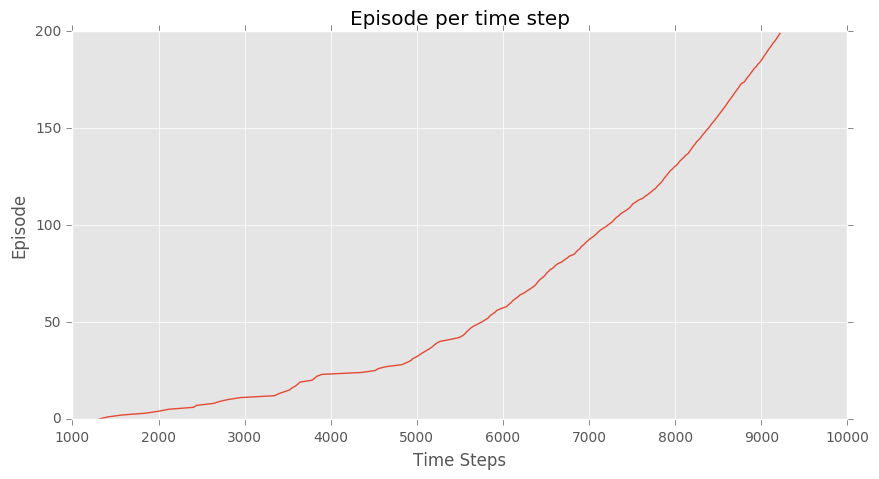

(<matplotlib.figure.Figure at 0x7f05ec2efb10>,
 <matplotlib.figure.Figure at 0x7f05ec1ec050>)

In [118]:
plotting.plot_episode_stats(stats)

In [119]:
s = env.reset()

In [120]:
s = env.reset()
done = False
while not done:
    env.render()
    a = one_step_lookahead(s, policy)
    s, r, done, _ = env.step(a)

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o

In [121]:
np.random.uniform()

0.004405865805743314